In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime,timedelta


Stock Predictor Class

In [105]:
class StockPredictor:
    def __init__(self, symbols, start_date, end_date, prediction_days=60):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.prediction_days = prediction_days
        self.models = {}
        self.scalers = {}
        self.data = {}
        
    def fetch_data(self):
        """Fetch historical data for all symbols"""
        for symbol in self.symbols:
            stock = yf.Ticker(symbol)
            self.data[symbol] = stock.history(start=self.start_date, end=self.end_date)
            print(f"Fetched {len(self.data[symbol])} days of data for {symbol}")
            
    def prepare_data(self, symbol):
        """Prepare data for training"""
        df = self.data[symbol].copy()
        
        # Handle any missing values in core features
        df['Close'] = df['Close'].ffill()
        df['Volume'] = df['Volume'].fillna(df['Volume'].mean())
        
        # Calculate technical indicators
        df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
        df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()
        df['RSI'] = self._calculate_rsi(df['Close'])
        df['MACD'] = self._calculate_macd(df['Close'])
        
        # Create features and target
        features = ['Close', 'Volume', 'MA20', 'MA50', 'RSI', 'MACD']
        
        # Handle NaN values using modern methods
        df[features] = df[features].ffill().bfill()
        
        # Verify no NaN values remain
        if df[features].isna().any().any():
            raise ValueError(f"NaN values still present in {symbol} data after cleaning")
        
        # Scale the features
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[features])
        self.scalers[symbol] = scaler
        
        X, y = [], []
        for i in range(self.prediction_days, len(scaled_data)):
            X.append(scaled_data[i-self.prediction_days:i])
            y.append(scaled_data[i, 0])  # Predicting the Close price
            
        return np.array(X), np.array(y)
    
    def _calculate_rsi(self, prices, period=14):
        """Calculate Relative Strength Index"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
        # Avoid division by zero
        loss = loss.replace(0, np.finfo(float).eps)
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    def _calculate_macd(self, prices, fast=12, slow=26, signal=9):
        """Calculate MACD (Moving Average Convergence Divergence)"""
        exp1 = prices.ewm(span=fast, adjust=False).mean()
        exp2 = prices.ewm(span=slow, adjust=False).mean()
        macd = exp1 - exp2
        return macd
    
    def build_model(self):
        """Build LSTM model"""
        model = Sequential([
            LSTM(units=50, return_sequences=True, input_shape=(self.prediction_days, 6)),
            Dropout(0.2),
            LSTM(units=50, return_sequences=True),
            Dropout(0.2),
            LSTM(units=50),
            Dropout(0.2),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model
    
    def train_models(self, epochs=50, batch_size=32, validation_split=0.1):
        """Train models for all symbols"""
        for symbol in self.symbols:
            print(f"\nTraining model for {symbol}")
            X, y = self.prepare_data(symbol)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            model = self.build_model()
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
                verbose=1
            )
            
            self.models[symbol] = model
            
            # Evaluate model
            y_pred = model.predict(X_test, verbose=0)
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            print(f"\nModel evaluation metrics for {symbol}:")
            print(f"MSE: {mse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"R2 Score: {r2:.4f}")
    
    def predict_next_days(self, days=30):
        """Predict stock prices for the next specified days"""
        predictions = {}
        
        for symbol in self.symbols:
            # Get the data and calculate indicators
            df = self.data[symbol].copy()
            
            # Calculate technical indicators
            df['MA20'] = df['Close'].rolling(window=20, min_periods=1).mean()
            df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()
            df['RSI'] = self._calculate_rsi(df['Close'])
            df['MACD'] = self._calculate_macd(df['Close'])
            
            # Handle any NaN values using modern methods
            features = ['Close', 'Volume', 'MA20', 'MA50', 'RSI', 'MACD']
            df[features] = df[features].ffill().bfill()
            
            # Get the last sequence
            last_sequence = df[features].tail(self.prediction_days).values
            
            # Scale the sequence
            scaled_sequence = self.scalers[symbol].transform(last_sequence)
            
            # Make predictions
            symbol_predictions = []
            current_sequence = scaled_sequence.copy()
            
            for _ in range(days):
                # Reshape for LSTM input
                current_input = current_sequence.reshape(1, self.prediction_days, len(features))
                # Predict next day
                predicted_scaled = self.models[symbol].predict(current_input, verbose=0)
                
                # Create a full feature vector for inverse transform
                last_features = current_sequence[-1].copy()
                last_features[0] = predicted_scaled[0][0]  # Update only the Close price
                
                # Update sequence for next prediction
                new_sequence = np.roll(current_sequence, -1, axis=0)
                new_sequence[-1] = last_features
                current_sequence = new_sequence
                
                # Inverse transform to get the actual price
                predicted_price = self.scalers[symbol].inverse_transform(last_features.reshape(1, -1))[0][0]
                symbol_predictions.append(predicted_price)
            
            predictions[symbol] = symbol_predictions
            
        return predictions
    
    def plot_predictions(self, predictions):
        """Plot historical data and predictions for all symbols"""
        num_symbols = len(self.symbols)
        fig, axes = plt.subplots(num_symbols, 1, figsize=(15, 5*num_symbols))
        if num_symbols == 1:
            axes = [axes]
        
        for idx, symbol in enumerate(self.symbols):
            df = self.data[symbol]
            
            # Plot historical data
            axes[idx].plot(df.index[-100:], df['Close'][-100:], label='Historical Data')
            
            # Plot predictions
            last_date = df.index[-1]
            future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=len(predictions[symbol]))
            axes[idx].plot(future_dates, predictions[symbol], label='Predictions', linestyle='--')
            
            axes[idx].set_title(f'{symbol} Stock Price Prediction')
            axes[idx].set_xlabel('Date')
            axes[idx].set_ylabel('Price')
            axes[idx].legend()
            axes[idx].grid(True)
        
        plt.tight_layout()
        plt.show()

In [109]:
symbols = ['AAPL', 'GOOGL', 'MSFT']
start_date = '2020-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Initialize and train the predictor
predictor = StockPredictor(symbols, start_date, end_date)
predictor.fetch_data()
predictor.train_models()



Fetched 1283 days of data for AAPL
Fetched 1283 days of data for GOOGL
Fetched 1283 days of data for MSFT

Training model for AAPL
Epoch 1/50


/opt/anaconda3/envs/stock/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0841 - val_loss: 0.0051
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0044 - val_loss: 9.6695e-04
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0044 - val_loss: 9.7188e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0040 - val_loss: 8.6362e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0031 - val_loss: 8.8084e-04
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss

/opt/anaconda3/envs/stock/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0839 - val_loss: 0.0067
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0100 - val_loss: 0.0030
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0037 - val_l

/opt/anaconda3/envs/stock/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0892 - val_loss: 0.0038
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0080 - val_loss: 0.0016
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0052 - val_loss: 0.0014
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - val_l

/opt/anaconda3/envs/stock/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/stock/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/stock/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


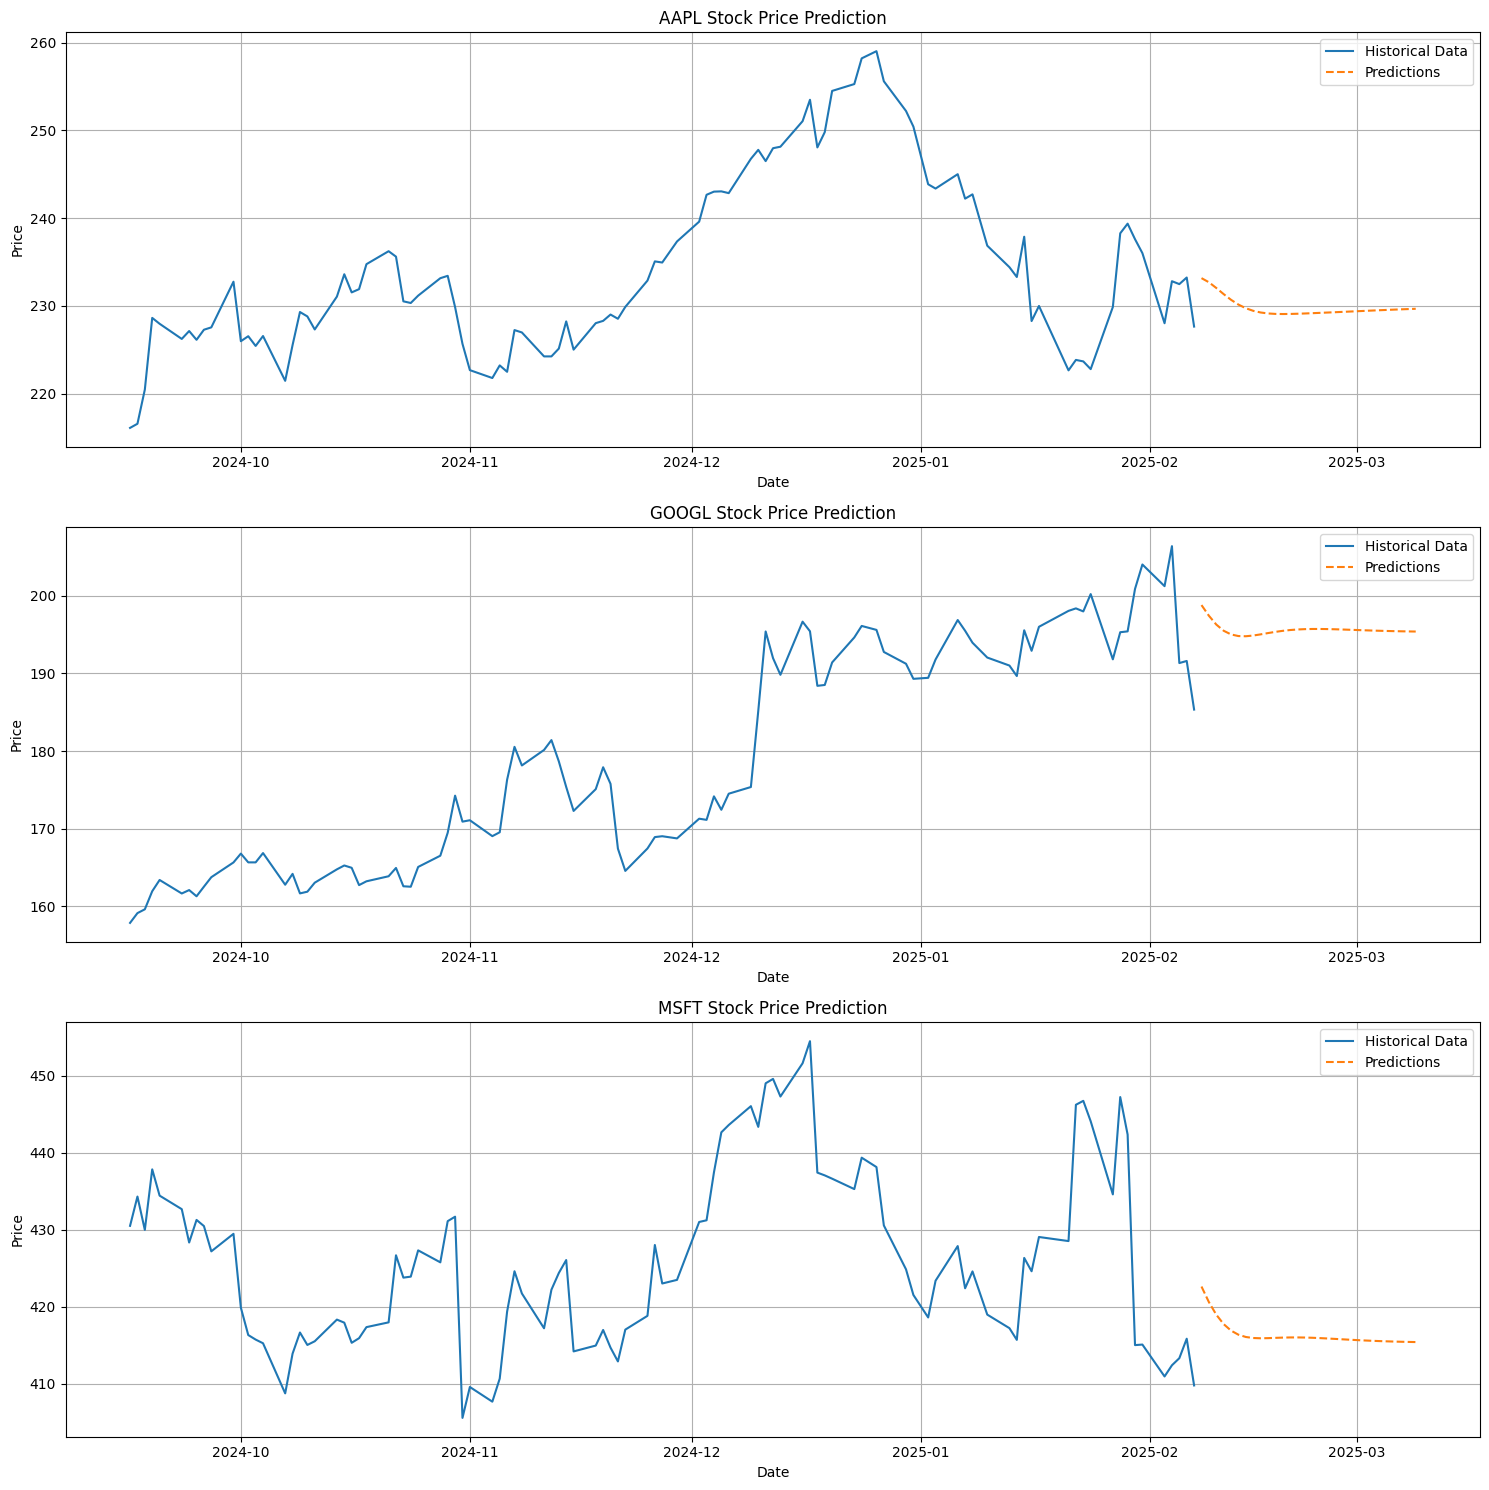

In [110]:
predictions = predictor.predict_next_days(days=30)
predictor.plot_predictions(predictions)